# 核図表を書いてみよう

このnotebookではAME2020のデータとKTUY05のデータを使ってMatplotlibで核図表を描くということを行う。

よく見かける液滴モデルと実際の測定値の質量欠損の差を描画し、殻効果を実感したいと思う。

まずは必要なライブラリをimportするとともに定数を宣言する。

In [20]:
import csv
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [21]:
MASS_PROTON = 938.272
MASS_NEUTRON = 939.56541
MASS_HYGROGEN = 938.783263

# AME2020の取得と計算

この節では評価済みの原子質量の値を取得し、液滴モデルによる質量欠損の計算を行う。

データは[IAEA Atomic Mass Data Center](https://www-nds.iaea.org/amdc/)の[AME2020](https://www-nds.iaea.org/amdc/ame2020/mass_1.mas20.txt)から取得する。

すでにinput内の[ame2020.txt](./input/ame2020.txt)に取得したデータが入っている。

まずはCSVに変更する。

In [3]:
input_file_path = os.path.join('input', 'ame2020.txt')
output_file_path = os.path.join('output', 'ame2020.csv')

In [4]:
field_widths = [
    1, 3, 5, 5, 5, 1, 3, 4, 1, 14, 12, 13, 1, 10, 1, 2, 13, 11, 1, 3, 1, 13, 12
]

labels = ["NZ", "N", "Z", "A", "el", "o", "mass", "unc_mass", "binding", "unc_binding", "B", "beta", "unc_beta", "atomic_mass1", "atomic_mass2", "unc_atomic_mass"]

with open(input_file_path, 'r') as file:
    lines = file.readlines()

data_to_write = [labels]

for line in lines[36:]:
    start = 0
    fields = []
    for width in field_widths:
        field = line[start:start + width].strip()
        start += width
        if width > 1:  # 1xを無視
            fields.append(field)
    data_to_write.append(fields)

with open(output_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerows(data_to_write)

作成したCSVを読み込んできて質量欠損の列をdouble型に変更する

In [ ]:
ame20 = pd.read_csv('./output/ame2020.csv')

In [6]:
ame20 = ame20.rename(columns={'mass': 'M_ex'})
ame20['M_ex'] = pd.to_numeric(ame20['M_ex'], errors='coerce')
dum = ame20.dropna(subset=['M_ex'])
ame20 = dum .reset_index(drop=True)

## 液滴モデルによる質量欠損を計算する

[Bethe–Weizsäckeの半経験的質量公式](https://ja.wikipedia.org/wiki/%E3%83%99%E3%83%BC%E3%83%86%E3%83%BB%E3%83%B4%E3%82%A1%E3%82%A4%E3%83%84%E3%82%BC%E3%83%83%E3%82%AB%E3%83%BC%E3%81%AE%E5%85%AC%E5%BC%8F)
を用いて質量欠損を計算していく。

核係数に関しては文献ごとに微妙な違いがあるがここではあまり気にしない。

In [7]:
def calc_weizsacker_mass(data, label="M_wb"):

  data[label] = data.M_ex

  for i in range(len(data)):
    Z=data.Z[i]
    N=data.N[i]
    A = Z + N

    bvol   = 15.67
    bsurf  = 17.23
    bCoul  = 0.714
    bsym  = 93.13
    bpair  = 11.2

    Evol  =  bvol  * A
    Esurf = -bsurf  * A**(2./3.)
    Ecoul = -bCoul * Z * (Z-1) * A**(-1./3.)
    Esym = -bsym * (N-Z)**2 / (4.0*A)
    Epair = 0
    if ((A%2==0) and (Z%2==0)):
      Epair =  bpair * A**(-1./2.)
    if ((A%2==0) and (Z%2!=0)):
      Epair = -bpair * A**(-1./2.)
    B = Evol + Esurf + Ecoul + Esym + Epair

    data.loc[i, label] =  ( MASS_HYGROGEN * Z + MASS_NEUTRON * N - B - 931.494 * A ) * 1.e3

In [8]:
calc_weizsacker_mass(ame20, "M_wb")

In [9]:
output_file_path = os.path.join('output', 'ame2020_wb.csv')
ame20.to_csv(output_file_path)

# KTUYの取得と存在限界の計算

次に公開されてる質量の質量公式を使って現実世界に存在しうる原子核を調べる

まずは公開データですが、[KTUY質量公式](https://wwwndc.jaea.go.jp/nucldata/mass/KTUY04_J.html)にある[KTUY05_m246.dat](https://wwwndc.jaea.go.jp/nucldata/mass/KTUY05_m246.dat)をしようする。


参考文献
 
- H. Koura, T. Tachibana, M. Uno and M. Yamada, RIKEN Accel. Prog. Rep. 36 (2003) 9: H. Koura, TOURS Symposium on Nuclear Physics V, AIP Proceedings 704 (2004) 60.
- H. Koura, T. Tachibana, M. Uno and M. Yamada, Prog. Theor. Phys. 113 (2005) 305.
- H. Koura, M. Uno, T. Tachibana and M. Yamada, Nucl. Phys. A674 (2000) 47.
- G. Audi and A.H. Wapstra, Nucl. Phys. A595 (1995) 409.
- G. Audi, A.H. Wapstra and C. Thibault, Nucl. Phys. A729 (2003) 337.

まずはデータを取得し、CSVファイルに変更する。

In [10]:
input_file_path = os.path.join('input', 'ktuy05.txt')
output_file_path = os.path.join('output', 'ktuy05.csv')

In [11]:
with open(input_file_path, 'r') as file:
    lines = file.readlines()

labels = ["ZZ", "NN", "Mcal", "Esh", "alpha2", "alpha4", "alpha6"]

data_to_write = [labels]

for line in lines[1:]:
    fields = line.split()
    data_to_write.append(fields)

with open(output_file_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerows(data_to_write)

In [12]:
ktuy = pd.read_csv('./output/ktuy05.csv')
ktuy = ktuy.rename(columns={'ZZ': 'Z', 'NN': 'N', 'Mcal': 'M_ex'})

## 存在限界を計算する

さて存在限界ですが、基本的には1及び2中性子(陽子)分離エネルギーを計算すれば良い。

中性子分離エネルギーとは、原子核から中性子を一つ抜きだすときに必要なエネルギーである。

化学式っぽく描くと$ M(Z,N) + S_n \rightarrow M(Z,N-1) + n $のような感じである。

つまり$S_n$が負の値であれば外部からエネルギーを与えずとも分離できるのでそのような計算を行えば良い。

ただし原子核内の核子には対相関があり一つの中性子を抜き取るより二つの中性子を対を抜き去る方が得だったりする。

そのため2中性子(陽子)分離エネルギーも計算し、これらの値が全て正の場合のみ存在しうると考える。

KTUY質量公式では分離エネルギーは以下のように定義される。

$$
\begin{align}
S_{n } &= M_\mathrm{cal}(Z, N − 1)c^2 − M_\mathrm{cal}(Z, N)c^2 + 8.071 &\quad\mathrm{MeV} \\
S_{2n} &= M_\mathrm{cal}(Z, N − 2)c^2 − M_\mathrm{cal}(Z, N)c^2 + 8.071 \times 2 &\quad\mathrm{MeV} \\ 
S_{p } &= M_\mathrm{cal}(Z − 1, N)c^2 − M_\mathrm{cal}(Z, N)c^2 + 7.289 &\quad\mathrm{MeV}  \\
S_{2p} &= M_\mathrm{cal}(Z − 2, N)c^2 − M_\mathrm{cal}(Z, N)c^2 + 7.289 \times 2 &\quad\mathrm{MeV}
\end{align}
$$

よってこの値を計算し、それか一つでも負の場合はデータを捨てる。

In [13]:
def extract_value(df, condition1, condition2, target_column):
    filtered_df = df[condition1 & condition2]
    if len(filtered_df) == 1:
        return filtered_df[target_column].iloc[0]
    else:
        return np.NaN

def calculate_separation_energy(data, zshift, nshift):
    column_name = "S_Z" + str(zshift) + "N" + str(nshift)
    data[column_name] = 0.0

    for i in range(len(data)):
        condition1 = data['Z'] == (data.loc[i, 'Z'] - zshift)
        condition2 = data['N'] == (data.loc[i, 'N'] - nshift)
        
        try:
            result = extract_value(data, condition1, condition2, 'M_ex')
            data.loc[i, column_name] = result - data['M_ex'][i] + 8.071 * nshift + 7.289 * zshift
        except ValueError as e:
            data.loc[i, column_name] = None
            print(e)
    
    data1 = data.dropna(subset=column_name)
    data2 = data1.reset_index(drop=True)
    return data2
            
def calculate_one_and_two_separation_energy(data):
    data1 = calculate_separation_energy(data, 0, 1)
    data2 = calculate_separation_energy(data1, 0, 2)
    data3 = calculate_separation_energy(data2, 1, 0)
    data4 = calculate_separation_energy(data3, 2, 0)
    return data4

def check_exsit(data):
    columns_to_check = ['S_Z1N0', 'S_Z2N0', 'S_Z0N1', 'S_Z0N2']
    data['exist'] = data[columns_to_check].apply(lambda row: None if any(row < 0) else 'valid', axis=1)
    data1 = data.dropna(subset='exist')
    data2 = data1.reset_index(drop=True)
    return data2

In [14]:
ktuy = calculate_one_and_two_separation_energy(ktuy)
ktuy = check_exsit(ktuy)

In [15]:
output_file_path = os.path.join('output', 'ktuy05_exist.csv')
ktuy.to_csv(output_file_path)

# 核図表を描画する

これまで計算してきた値を使って図を描画する。

In [16]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [17]:
ktuy = pd.read_csv('./output/ktuy05_exist.csv')
ame20 = pd.read_csv('./output/ame2020_wb.csv')
ktuy_magic = pd.read_csv('./input/magic_number_ktuy05.csv')
sabilities = pd.read_csv('./input/stable_nuclei.csv')
isgmr = pd.read_csv('./input/ISGMR.csv')

## 質量欠損を描画する

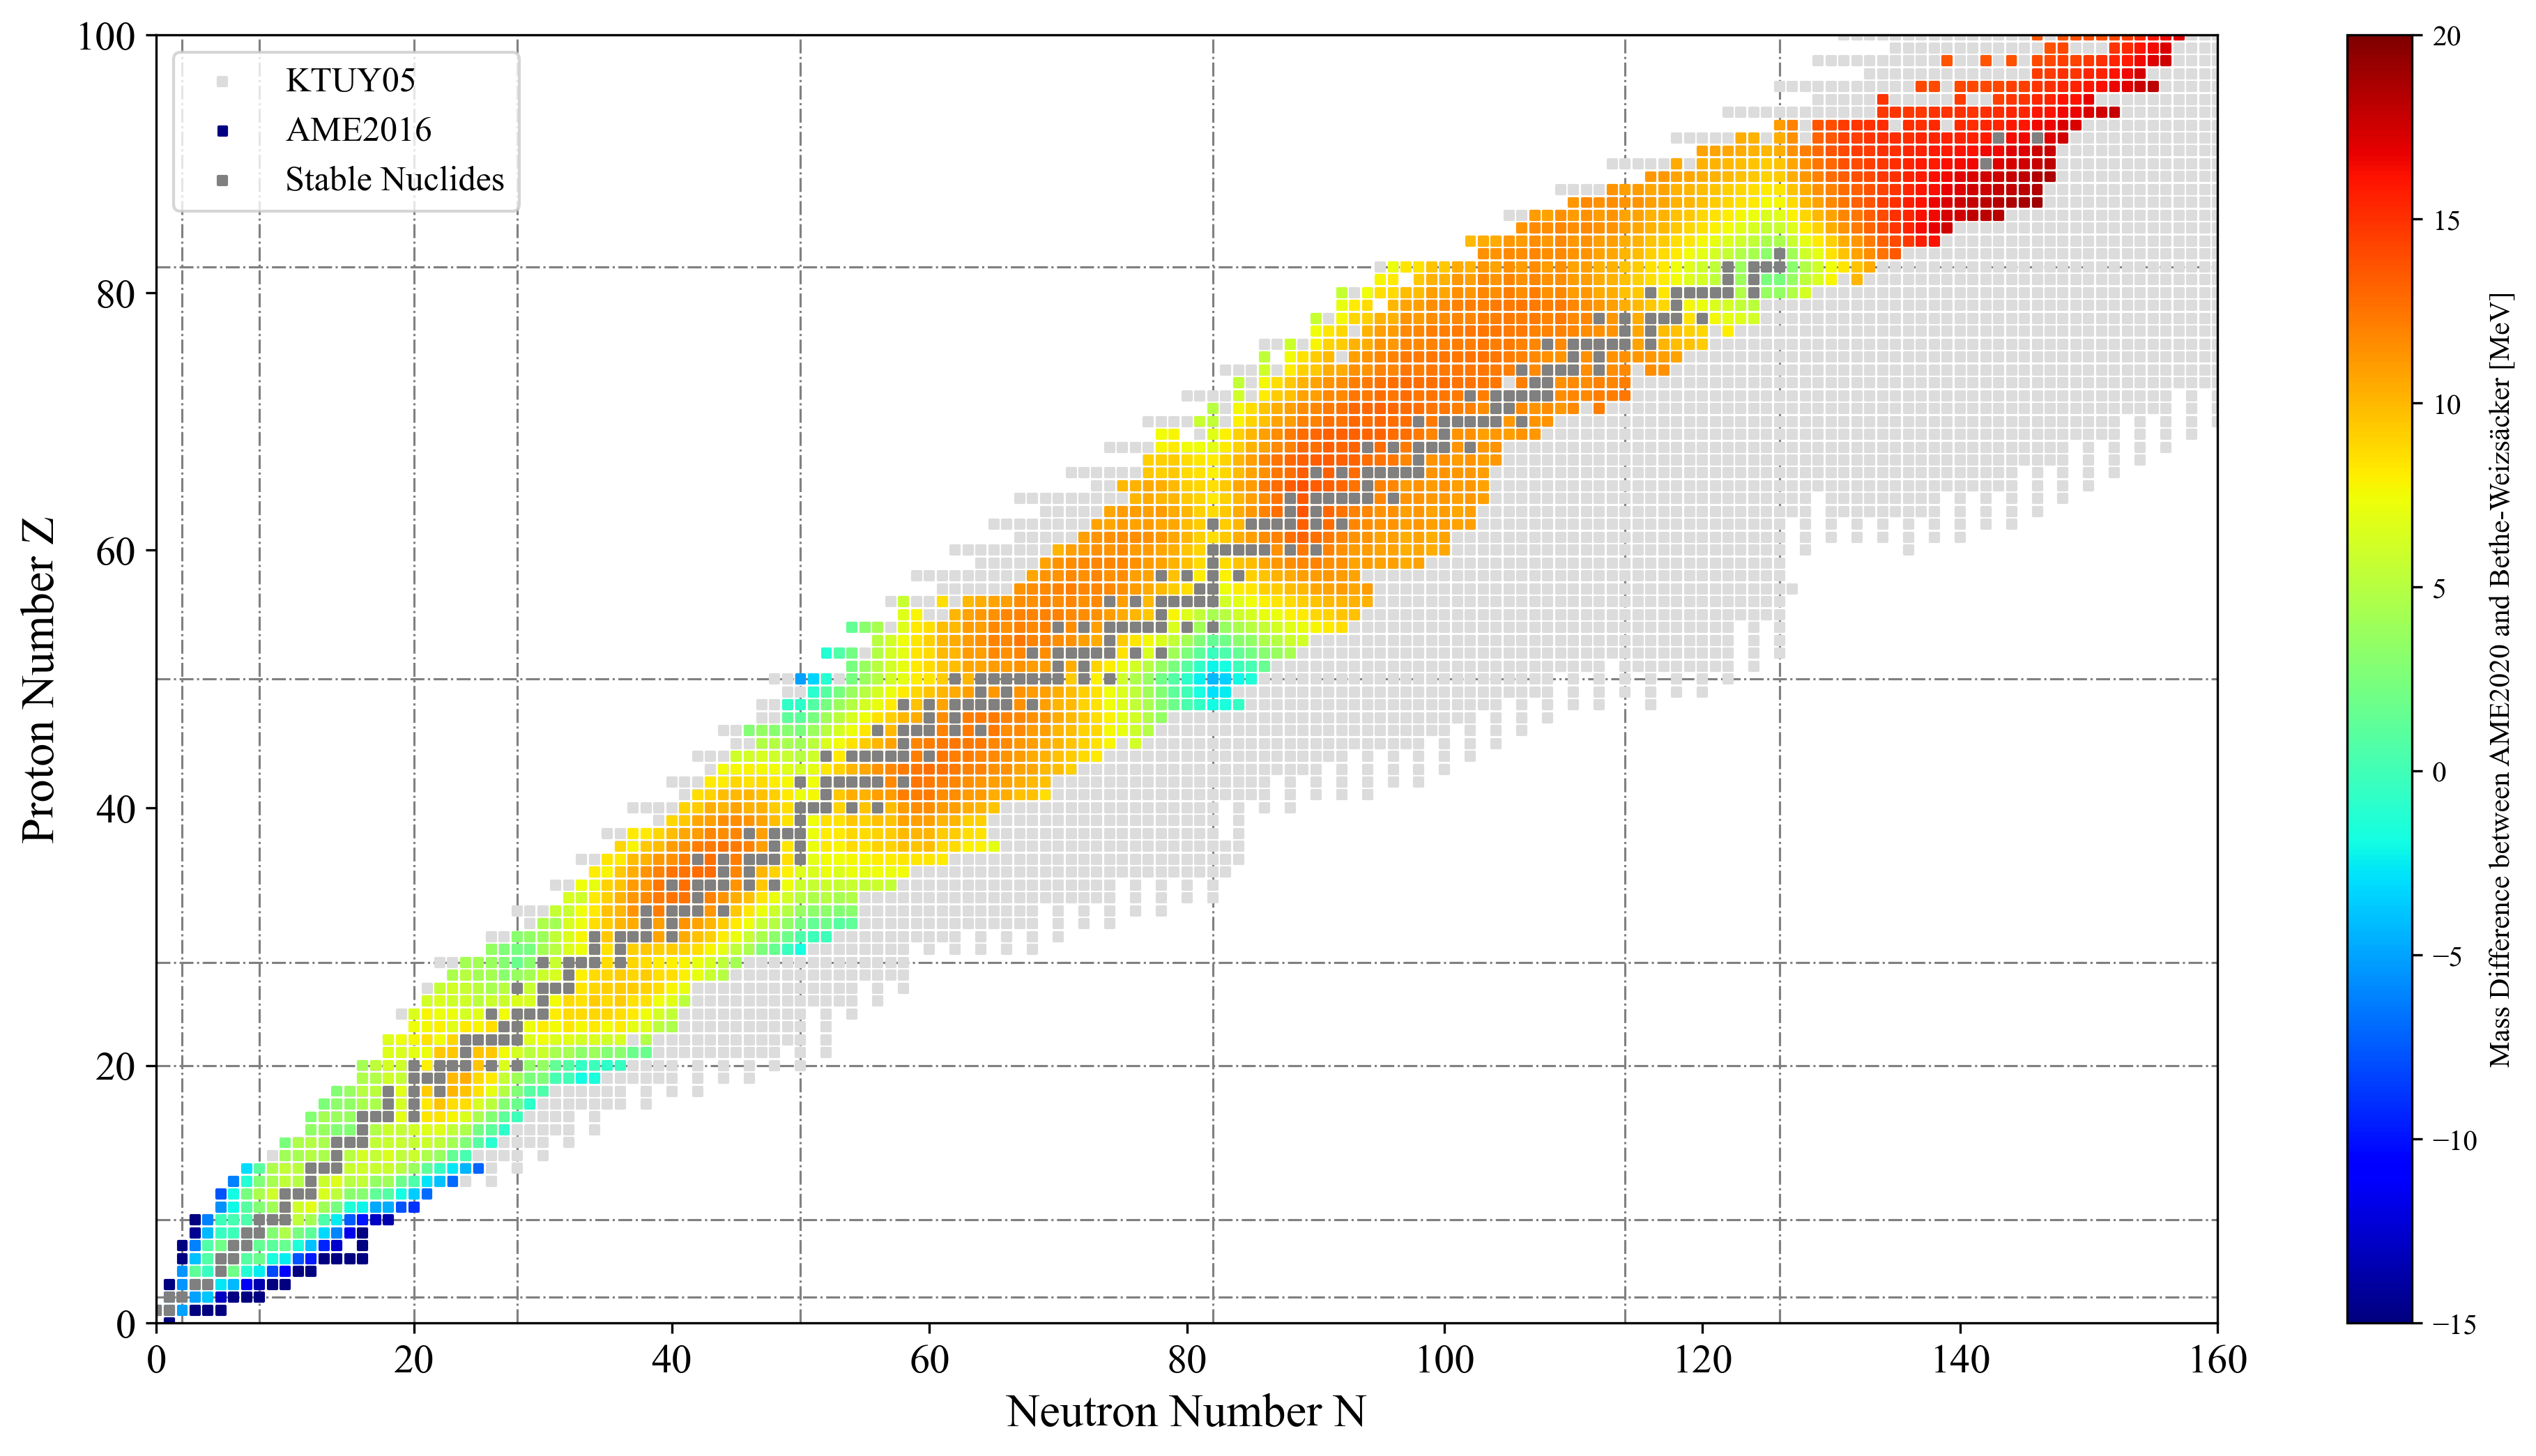

In [22]:
SCALE_FACTOR = 1.0

n_range = [0, 160 * SCALE_FACTOR]
p_range = [0, 100 * SCALE_FACTOR]

fig = plt.figure( figsize=(16, 8), dpi=300 )
fig.patch.set_alpha(0.)
ax = fig.add_subplot(111)
ax.patch.set_alpha(0.)

for i in range( len( ktuy_magic ) ):
    if not np.isnan( ktuy_magic.N[i] ):
        valmagic = [ float( ktuy_magic.N[i] ), float( ktuy_magic.N[i] ) ]
        ax.plot( n_range, valmagic, color="gray", zorder=-1, lw=0.75, ls='-.' )
        
    if not np.isnan( float( ktuy_magic.Z[i] ) ):
        valmagic = [ float( ktuy_magic.Z[i] ), float( ktuy_magic.Z[i] ) ]
        ax.plot(valmagic, p_range, color="gray", zorder=-1, lw=0.75, ls='-.' )


ax.scatter( ktuy.N, ktuy.Z, s=8/SCALE_FACTOR, marker=",", color="#dcdcdc", label="KTUY05" )

cmp = ax.scatter( ame20.N, ame20.Z, c=(ame20.M_ex-ame20.M_wb)/1.e3, cmap='jet', vmin=-15, vmax=20, s=8/SCALE_FACTOR, marker=",", label=r'AME2016' )
ax.scatter( sabilities.N, sabilities.Z, s=8/SCALE_FACTOR ,marker=",", color="#808080", label="Stable Nuclides" )

ax.set_axisbelow( True )
ax.set_xlim( n_range )
ax.set_ylim( p_range )
ax.set_aspect( 'equal' )
ax.set_ylabel( "Proton Number Z", fontsize=16 )
ax.set_xlabel( "Neutron Number N", fontsize=16 )
plt.colorbar(cmp).set_label( r'Mass Difference between AME2020 and Bethe-Weizsäcker [MeV]' )
plt.tick_params( labelsize=14 )
plt.legend( fontsize=12, loc='upper left' )
plt.show()

if True:
 fig.savefig("figs/Mass_NuclearChart.png")
 fig.savefig("figs/Mass_NuclearChart.pdf")

## (追加)準運動学によるISGMRの測定がなされた原子核を核図表上に描画する。

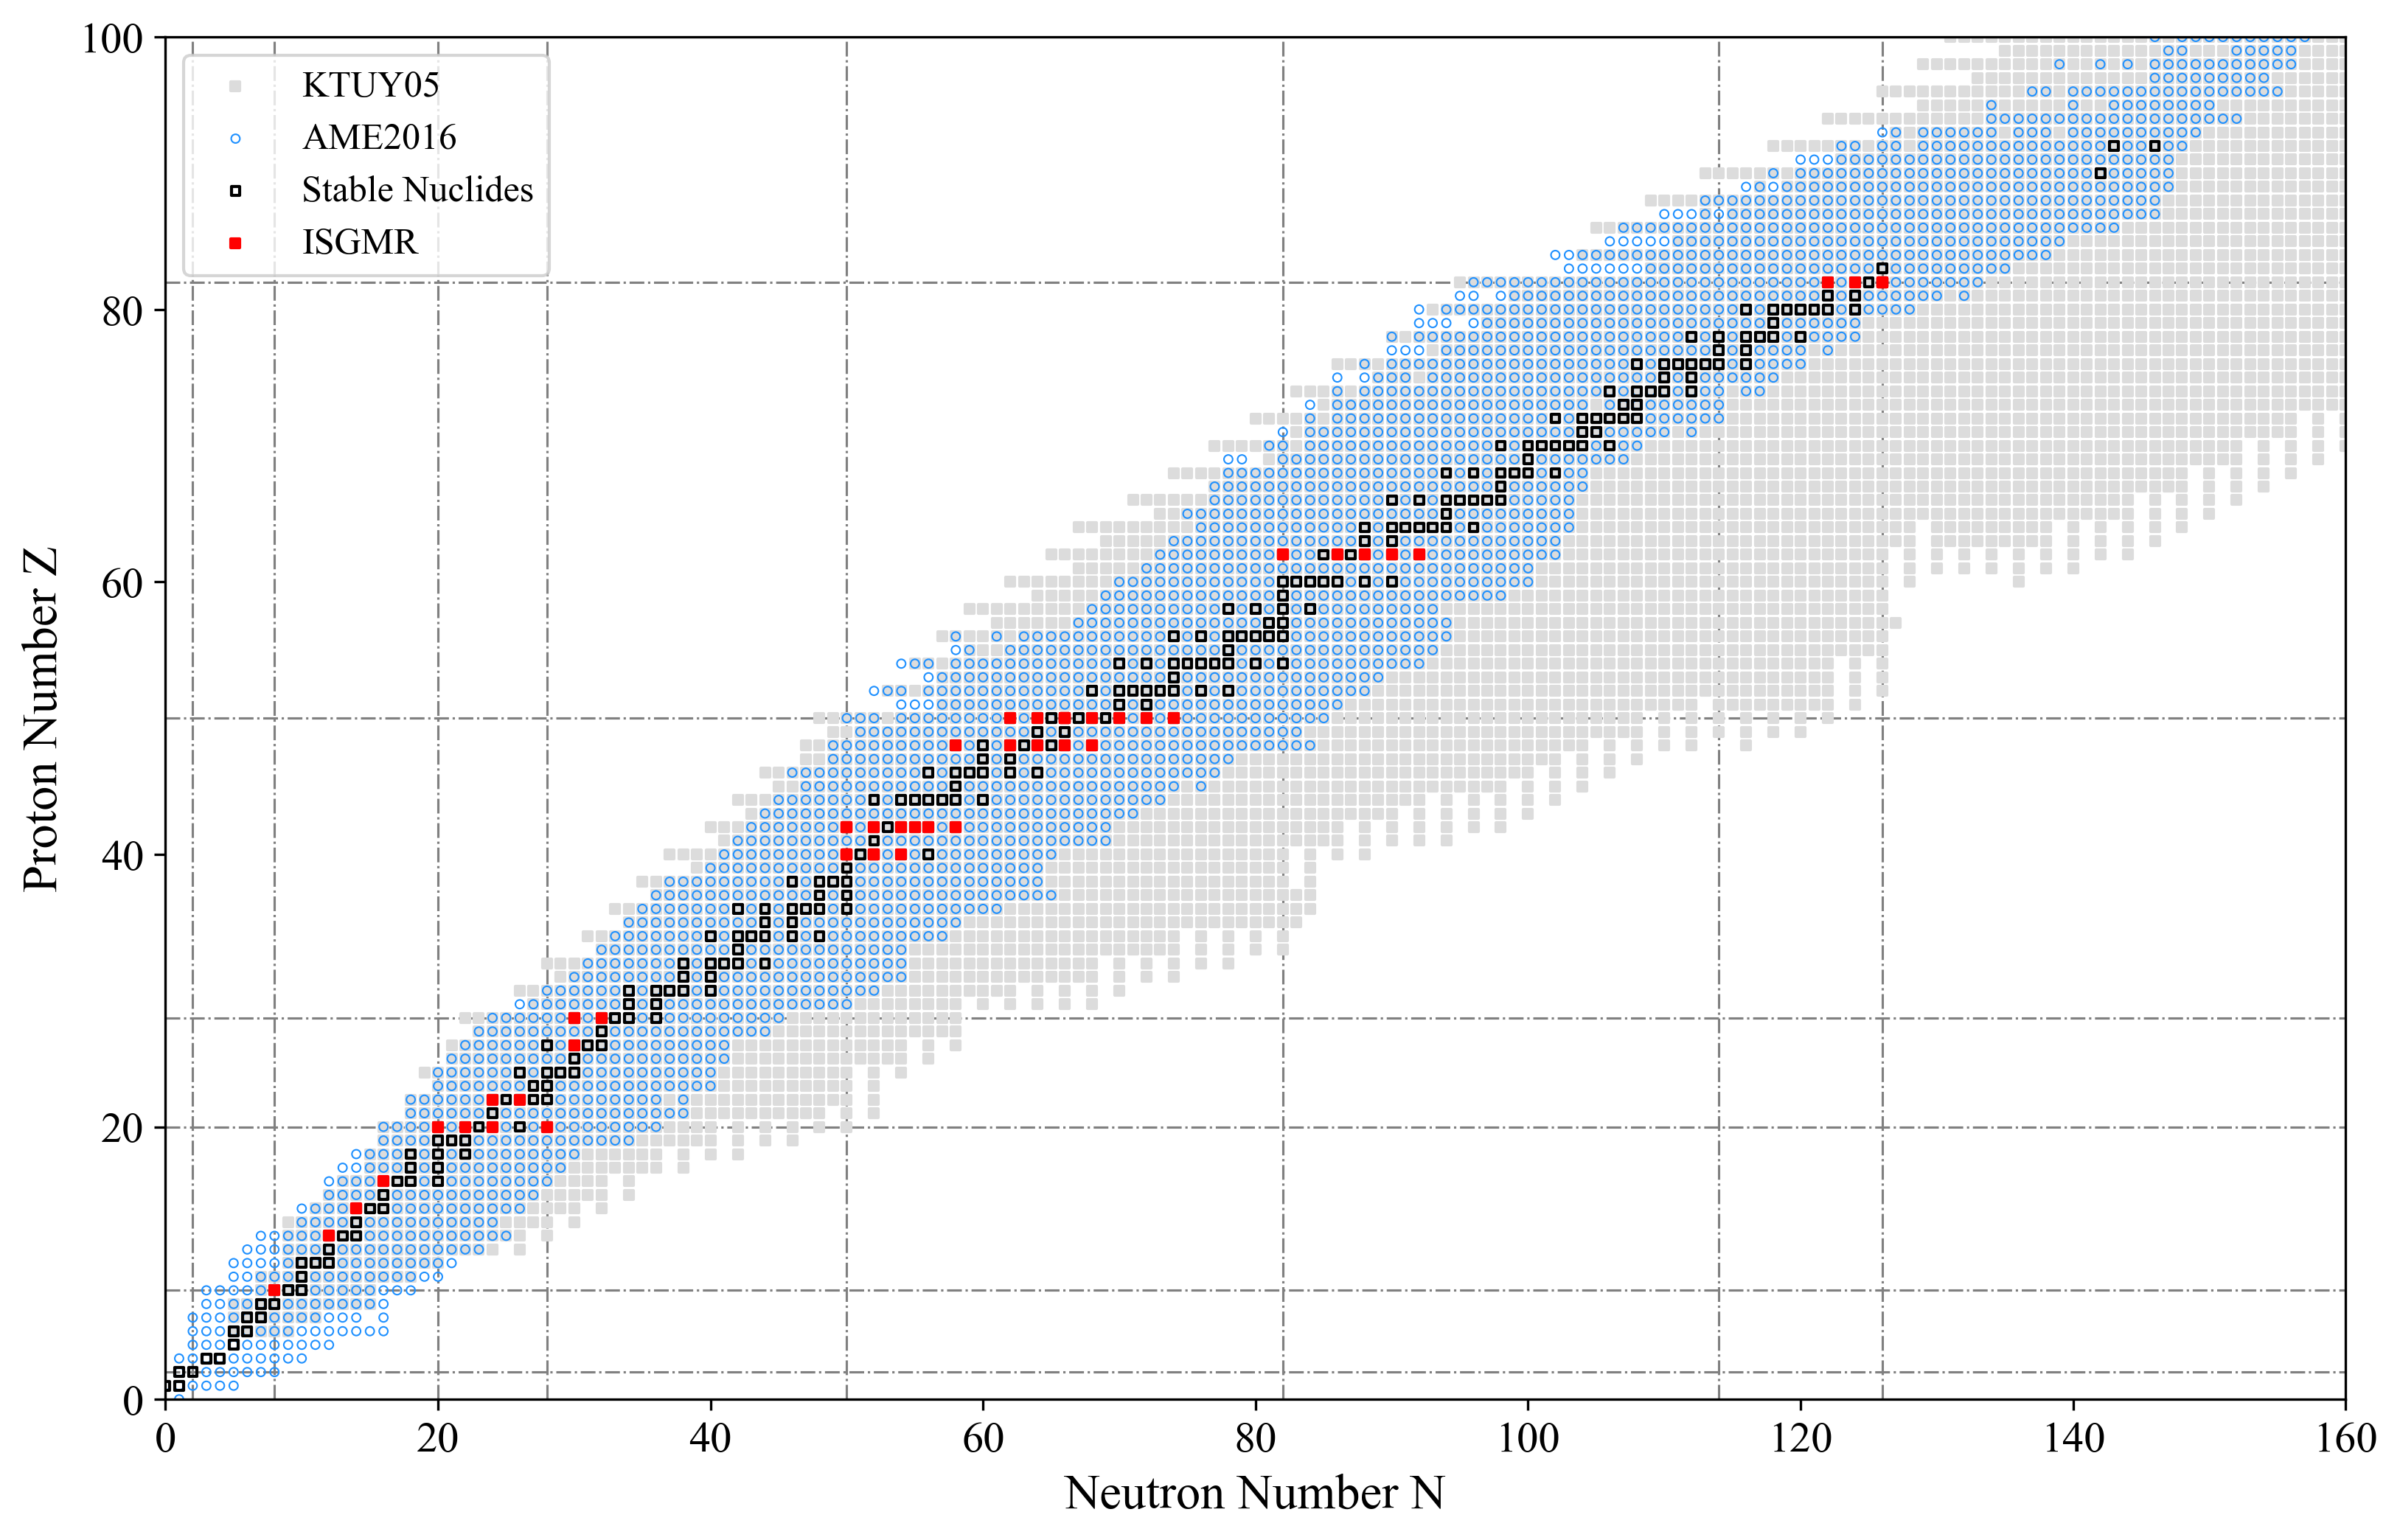

In [23]:
SCALE_FACTOR = 1.0

n_range = [0, 160 * SCALE_FACTOR]
p_range = [0, 100 * SCALE_FACTOR]

fig = plt.figure( figsize=(16, 8), dpi=300 )
fig.patch.set_alpha(0.)
ax = fig.add_subplot(111)
ax.patch.set_alpha(0.)

for i in range( len( ktuy_magic ) ):
    if not np.isnan( ktuy_magic.N[i] ):
        valmagic = [ float( ktuy_magic.N[i] ), float( ktuy_magic.N[i] ) ]
        ax.plot( n_range, valmagic, color="gray", zorder=-1, lw=0.75, ls='-.' )
        
    if not np.isnan( float( ktuy_magic.Z[i] ) ):
        valmagic = [ float( ktuy_magic.Z[i] ), float( ktuy_magic.Z[i] ) ]
        ax.plot(valmagic, p_range, color="gray", zorder=-1, lw=0.75, ls='-.' )

ax.scatter( ktuy.N, ktuy.Z, s=8/SCALE_FACTOR, marker=",", color="#dcdcdc", label="KTUY05" )
ax.scatter( ame20.N, ame20.Z, s=8/SCALE_FACTOR, marker="o", color="none", edgecolors="#1e90ff", linewidths=0.5, label="AME2016")
ax.scatter( sabilities.N, sabilities.Z, s=8/SCALE_FACTOR ,marker=",", color="none", edgecolors="#000000", linewidths=1, label="Stable Nuclides")
ax.scatter( isgmr.N, isgmr.Z, s=8/SCALE_FACTOR, marker=",", color="#ff0000", label=r'ISGMR')

ax.set_axisbelow( True )
ax.set_xlim( n_range )
ax.set_ylim( p_range )
ax.set_aspect( 'equal' )
ax.set_ylabel( "Proton Number Z", fontsize=16 )
ax.set_xlabel( "Neutron Number N", fontsize=16 )
plt.tick_params( labelsize=14 )
plt.legend( fontsize=12, loc='upper left' )
plt.show()

if True:
 fig.savefig("figs/ISGMR_NuclearChart.png")
 fig.savefig("figs/ISGMR_NuclearChart.pdf")